<a href="https://colab.research.google.com/github/butter-my-toast/TrafficCollisionML/blob/main/traffic_collision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**In our increasingly road-connected world, traffic collision fatalities are steadily on the rise.**

#### According to the [CDC](https://www.cdc.gov/injury/features/global-road-safety/), "Road traffic crashes are a leading cause of death in the United States for people ages 1–54, and they are the leading cause of nonnatural death for U.S. citizens residing or traveling abroad."

#### This machine learning project focuses on traffic collisions in California. It aims to be able to predict the severity of a traffic collision, only using variables known before the collision, using data from the California Highway Patrol's SWITRS database, through [Alex Gude's Kaggle repository](https://www.kaggle.com/datasets/alexgude/california-traffic-collision-data-from-switrs).

In [2]:
from google.colab import files
import pandas as pd
import os
import sqlite3
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from google.colab.data_table import DataTable
DataTable.max_columns = 75

####First, upload a Kaggle API key to download the dataset.

In [3]:
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d alexgude/california-traffic-collision-data-from-switrs
! unzip -q california-traffic-collision-data-from-switrs.zip

Saving kaggle.json to kaggle.json
 99% 1.49G/1.50G [00:11<00:00, 142MB/s]
100% 1.50G/1.50G [00:11<00:00, 142MB/s]


 #### Now, connect to the dataset using SQLite and select the features we to use.
 (I chose these features through much testing.)

In [4]:
cnx = sqlite3.connect('/content/switrs.sqlite')
cursor = cnx.cursor()

In [5]:
FINAL_QUERY = """
SELECT longitude, latitude, intersection, road_surface, lighting, state_highway_indicator, weather_1, weather_2, collision_time, collision_severity, collision_date FROM collisions
"""

df = pd.read_sql(FINAL_QUERY, cnx)
df

,longitude,latitude,intersection,road_surface,lighting,state_highway_indicator,weather_1,weather_2,collision_time,collision_severity,collision_date
0,NaN,NaN,1.0,dry,daylight,0.0,cloudy,None,07:45:00,property damage only,2020-03-14
1,NaN,NaN,NaN,dry,dark with street lights,0.0,clear,None,02:50:00,property damage only,2020-07-26
2,NaN,NaN,1.0,dry,daylight,0.0,clear,None,17:11:00,property damage only,2009-02-03
3,NaN,NaN,0.0,dry,dark with no street lights,1.0,clear,None,01:45:00,property damage only,2009-02-28
4,-118.28533,33.86465,0.0,wet,daylight,1.0,raining,None,10:20:00,property damage only,2009-02-09
...,...,...,...,...,...,...,...,...,...,...,...
9424329,-117.47220,33.43440,NaN,dry,daylight,0.0,clear,None,18:04:00,property damage only,2016-06-12
9424330,-122.18463,37.44952,1.0,dry,daylight,0.0,clear,None,10:00:00,property damage only,2016-05-11
9424331,NaN,NaN,0.0,dry,daylight,1.0,clear,None,15:31:00,pain,2016-08-15
9424332,NaN,NaN,0.0,dry,daylight,0.0,clear,None,07:53:00,pain,2016-08-18


In [6]:
df.isnull().sum()

longitude                  6730338
latitude                   6730338
intersection                 94500
road_surface                 81164
lighting                     53308
state_highway_indicator       3324
weather_1                    45221
weather_2                  9161454
collision_time               82415
collision_severity               0
collision_date                   0
dtype: int64

#### There are a lot of null values in the data, so these must be handled. Drop all of the null values and negligible values.
(ex: lighting as 'G' only occurs once in the entire dataset, so it may be a typo)

In [7]:
drop_df = df.dropna(subset=['lighting', 'intersection', 'longitude', 'latitude', 'road_surface', 'state_highway_indicator', 'collision_severity', 'weather_1', 'collision_time'])
drop_df = drop_df.drop(drop_df[drop_df['lighting'] == 'G'].index)
drop_df = drop_df.drop(drop_df[drop_df['road_surface'] == 'H'].index)
drop_df = drop_df.drop(drop_df[drop_df['road_surface'] == 'I'].index)
drop_df = drop_df.drop(drop_df[drop_df['road_surface'] == 'J'].index)
drop_df

,longitude,latitude,intersection,road_surface,lighting,state_highway_indicator,weather_1,weather_2,collision_time,collision_severity,collision_date
4,-118.28533,33.86465,0.0,wet,daylight,1.0,raining,None,10:20:00,property damage only,2009-02-09
5,-118.28230,33.79120,0.0,dry,daylight,1.0,clear,None,15:50:00,property damage only,2009-02-18
6,-118.35260,33.88450,0.0,dry,dusk or dawn,1.0,cloudy,None,17:35:00,property damage only,2009-02-11
7,-118.20906,33.83197,0.0,dry,dark with no street lights,1.0,clear,None,21:20:00,property damage only,2009-02-13
8,-118.20770,33.82693,0.0,dry,dark with no street lights,1.0,clear,None,20:40:00,pain,2009-02-13
...,...,...,...,...,...,...,...,...,...,...,...
9424325,-117.79989,34.02730,0.0,dry,daylight,1.0,clear,None,20:50:00,property damage only,2015-11-30
9424326,-117.39960,34.44470,0.0,dry,daylight,1.0,clear,None,14:25:00,pain,2016-03-23
9424328,-120.41725,34.95313,0.0,dry,dusk or dawn,1.0,clear,None,00:45:00,property damage only,2016-05-28
9424330,-122.18463,37.44952,1.0,dry,daylight,0.0,clear,None,10:00:00,property damage only,2016-05-11


####Now, take a look at the distribution of severities after the null values were dropped.


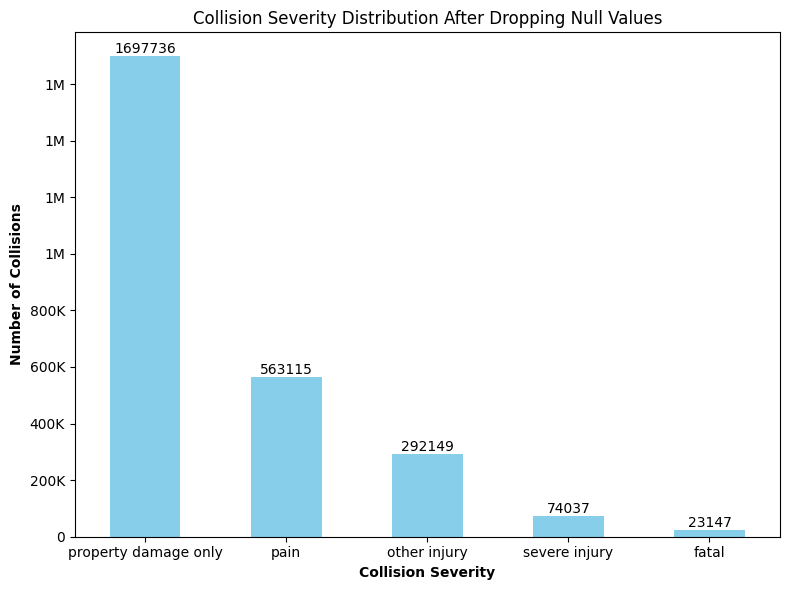

In [8]:
from matplotlib.ticker import FuncFormatter

severity_group_counts = drop_df['collision_severity'].value_counts()

plt.figure(figsize=(8, 6))
ax = severity_group_counts.plot(kind='bar', color='skyblue')
plt.title('Collision Severity Distribution After Dropping Null Values')
plt.xlabel('Collision Severity', fontweight='bold')
plt.ylabel('Number of Collisions', fontweight='bold')
plt.xticks(rotation=0)
def format_large_tick_values(tick_val, tick_pos):
    if tick_val >= 1e6:
        val = int(tick_val / 1e6)
        return f'{val}M'
    elif tick_val >= 1e3:
        val = int(tick_val / 1e3)
        return f'{val}K'
    else:
        return int(tick_val)

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_large_tick_values))

for i, v in enumerate(severity_group_counts):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()

#### **Clearly this is not very balanced. Addressing this imbalance is crucial to prevent the predictive model from having a bias towards the dominant class (in this case, the nonsevere outcomes).**

#### So, I chose the distribution of severities myself. I tried to make the distribution more balanced, while still mirroring the distribution of the actual dataset.

#### The testing dataframe can not have a specifically chosen distribution though because the testing must be done on real-world values.

In [9]:
cut_df = pd.DataFrame()
sample_sizes = [90000, 20000, 72000, 10000, 22000] # property, pain, severe, other, fatal
test_df = drop_df.sample(int(0.1*sum(sample_sizes)), random_state = 21)
df_test_removed = drop_df.drop(test_df.index)

for i, severity in enumerate(drop_df['collision_severity'].unique()):
    subset = df_test_removed[df_test_removed['collision_severity'] == severity].sample(sample_sizes[i])
    cut_df = pd.concat([cut_df, subset], ignore_index=True)

cut_df

,longitude,latitude,intersection,road_surface,lighting,state_highway_indicator,weather_1,weather_2,collision_time,collision_severity,collision_date
0,-118.18592,33.87852,0.0,dry,daylight,1.0,clear,None,09:45:00,property damage only,2009-07-15
1,-117.90058,33.98572,0.0,dry,daylight,0.0,clear,None,18:35:00,property damage only,2009-07-13
2,-118.06580,34.00280,0.0,dry,daylight,1.0,clear,None,13:55:00,property damage only,2017-08-11
3,-118.07257,34.07379,0.0,dry,dark with no street lights,1.0,clear,None,22:38:00,property damage only,2017-05-11
4,-115.70881,35.43213,0.0,dry,dark with no street lights,1.0,clear,None,22:00:00,property damage only,2018-07-14
...,...,...,...,...,...,...,...,...,...,...,...
213995,-121.56151,38.75000,0.0,dry,dusk or dawn,0.0,clear,None,20:01:00,fatal,2015-08-09
213996,-115.43081,35.51562,0.0,dry,dark with no street lights,1.0,clear,None,00:09:00,fatal,2011-12-21
213997,-122.41047,38.24879,0.0,dry,daylight,1.0,clear,None,14:15:00,fatal,2010-06-13
213998,-121.44653,38.22194,0.0,wet,daylight,0.0,cloudy,raining,12:45:00,fatal,2013-11-20


In [10]:
cut_df['collision_severity'].value_counts()

property damage only    90000
severe injury           72000
fatal                   22000
pain                    20000
other injury            10000
Name: collision_severity, dtype: int64

#### **Now, it's time to do some feature transformation!**

- Categorical variables, namely 'weather_1', 'weather_2', 'lighting', and 'road_surface', were one-hot encoded.

- The 'collision_severity' variable was binary-encoded, with values of 'property damage only', 'pain', and 'other injury' assigned as 0, while 'severe injury' and 'fatal' were designated as 1.

- A binary 'weekend' feature was created from analyzing the 'collision_date' attribute.

- Addressing the cyclic nature of time-based features, such as 'collision_time' and 'collision_date', involved a distinct approach. Instead of conventional one-hot encoding, I utilized sine and cosine functions. This method ensured that all timepoints and dates were uniformly distributed in the transformed feature space.

- A custom transformation function was developed to convert time and date features into sine and cosine components. For each time point in 'collision_time' (ranging from 1 to 23) and 'collision_date' (ranging from 1 to 365), the corresponding sine and cosine values were calculated using mathematical formulas. These transformed features, denoted as 'collision_time_sin', 'collision_time_cos', 'collision_date_sin', and 'collision_date_cos', replaced the original time and date features in both the training and test datasets. This cyclical approach was taken from [Satyam Kumar](https://towardsdatascience.com/stop-one-hot-encoding-your-time-based-features-24c699face2f).


In [11]:
import math

label_mapping = {
    'property damage only': 0,
    'pain': 0,
    'other injury': 0,
    'severe injury': 1,
    'fatal': 1,
    None: None
}

cut_df = pd.get_dummies(cut_df, columns=['weather_1'], prefix='weather_1') # one-hot
cut_df = pd.get_dummies(cut_df, columns=['weather_2'], prefix='weather_2') # one-hot

cut_df = pd.get_dummies(cut_df, columns=['lighting'], prefix='lighting') # one-hot

cut_df['collision_severity'] = cut_df['collision_severity'].map(label_mapping)

cut_df['collision_time'] = pd.to_datetime(cut_df['collision_time'])
cut_df['collision_time'] = cut_df['collision_time'].dt.hour

cut_df = pd.get_dummies(cut_df, columns=['road_surface'], prefix='road_surface') # one-hot

cut_df['collision_date'] = pd.to_datetime(cut_df['collision_date'])
cut_df['weekend'] = cut_df['collision_date'].apply(lambda x: 1 if x.weekday() >= 5 else 0)

cut_df['collision_date'] = cut_df['collision_date'].dt.dayofyear

# cyclically-encoding the time
def transformation(column):
  max_value = column.max()
  sin_values = [math.sin((2*math.pi*x)/max_value) for x in list(column)]
  cos_values = [math.cos((2*math.pi*x)/max_value) for x in list(column)]
  return sin_values, cos_values

time_sin_values, time_cos_values = transformation(cut_df['collision_time'])
cut_df['collision_time_sin'] = time_sin_values
cut_df['collision_time_cos'] = time_cos_values

day_sin_values, day_cos_values = transformation(cut_df['collision_date'])
cut_df['collision_date_sin'] = day_sin_values
cut_df['collision_date_cos'] = day_cos_values

cut_df = cut_df.drop(['collision_time', 'collision_date'], axis=1)

test_df = pd.get_dummies(test_df, columns=['weather_1'], prefix='weather_1') # one-hot
test_df = pd.get_dummies(test_df, columns=['weather_2'], prefix='weather_2') # one-hot

test_df = pd.get_dummies(test_df, columns=['lighting'], prefix='lighting') # one-hot

test_df['collision_severity'] = test_df['collision_severity'].map(label_mapping)
test_df['collision_time'] = pd.to_datetime(test_df['collision_time'])
test_df['collision_time'] = test_df['collision_time'].dt.hour

test_df = pd.get_dummies(test_df, columns=['road_surface'], prefix='road_surface') # one-hot

test_df['collision_date'] = pd.to_datetime(test_df['collision_date'])
test_df['weekend'] = test_df['collision_date'].apply(lambda x: 1 if x.weekday() >= 5 else 0)

test_df['collision_date'] = test_df['collision_date'].dt.dayofyear

time_sin_values, time_cos_values = transformation(test_df['collision_time'])
test_df['collision_time_sin'] = time_sin_values
test_df['collision_time_cos'] = time_cos_values

day_sin_values, day_cos_values = transformation(test_df['collision_date'])
test_df['collision_date_sin'] = day_sin_values
test_df['collision_date_cos'] = day_cos_values

test_df = test_df.drop(['collision_time', 'collision_date'], axis=1)

cut_df.head()

,longitude,latitude,intersection,state_highway_indicator,collision_severity,weather_1_clear,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,...,lighting_dusk or dawn,road_surface_dry,road_surface_slippery,road_surface_snowy,road_surface_wet,weekend,collision_time_sin,collision_time_cos,collision_date_sin,collision_date_cos
0,-118.18592,33.87852,0.0,1.0,0.0,1,0,0,0,0,...,0,1,0,0,0,0,0.631088,-0.775711,-0.221325,-0.975200
1,-117.90058,33.98572,0.0,0.0,0.0,1,0,0,0,0,...,0,1,0,0,0,0,-0.979084,0.203456,-0.187719,-0.982223
2,-118.06580,34.00280,0.0,1.0,0.0,1,0,0,0,0,...,0,1,0,0,0,0,-0.398401,-0.917211,-0.633978,-0.773351
3,-118.07257,34.07379,0.0,1.0,0.0,1,0,0,0,0,...,0,1,0,0,0,0,-0.269797,0.962917,0.778764,-0.627317
4,-115.70881,35.43213,0.0,1.0,0.0,1,0,0,0,0,...,0,1,0,0,0,1,-0.269797,0.962917,-0.204552,-0.978856


#### Now, seperate both the train and test dataframe into their respective labels (y) and features (x)

In [12]:
cut_labels = pd.DataFrame(cut_df['collision_severity'])
cut_df = cut_df.drop(['collision_severity'], axis=1)

cut_labels_test = pd.DataFrame(test_df['collision_severity'])
cut_df_test = test_df.drop(['collision_severity'], axis=1)

#### Now, rename the dataframes for readability.

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
X_train, X_test, y_train, y_test = cut_df, cut_df_test, cut_labels, cut_labels_test
y_train, y_test = y_train['collision_severity'].ravel(), y_test['collision_severity'].ravel()

#### **Now, run each of the machine learning algorithms on the data.**

In [14]:
import sklearn.tree as tree
tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
tree_preds = tree_clf.predict(X_test)
print('Decision tree acc:', (accuracy_score(y_test, tree_preds)))

Decision tree acc: 0.6216822429906542


In [15]:
from sklearn.ensemble import RandomForestClassifier
forest100_clf = RandomForestClassifier(n_estimators=100)
forest100_clf.fit(X_train, y_train)
forest100_preds = forest100_clf.predict(X_test)
print('Random forest (100) acc:', (accuracy_score(y_test, forest100_preds)))

Random forest (100) acc: 0.6988785046728972


In [16]:
forest500_clf = RandomForestClassifier(n_estimators=500)
forest500_clf.fit(X_train, y_train)
forest500_preds = forest500_clf.predict(X_test)
print('Random forest (500) acc:', (accuracy_score(y_test, forest500_preds)))

Random forest (500) acc: 0.697196261682243


In [17]:
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)
gnb_preds = gnb_clf.predict(X_test)
print('Naive bayes acc:', (accuracy_score(y_test, gnb_preds)))

Naive bayes acc: 0.8539252336448598


In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
knn_preds = knn_clf.predict(X_test)
print('KNN acc:', (accuracy_score(y_test, knn_preds)))

KNN acc: 0.6831308411214954


In [19]:
from sklearn.ensemble import GradientBoostingClassifier
gradboost_clf1 = GradientBoostingClassifier(learning_rate = 0.1)
gradboost_clf1.fit(X_train, y_train)
gradboost_preds1 = gradboost_clf1.predict(X_test)
print('Grad boost (lr=0.1) acc:', (accuracy_score(y_test, gradboost_preds1)))

Grad boost (lr=0.1) acc: 0.7406074766355141


In [20]:
gradboost_clf2 = GradientBoostingClassifier(learning_rate = 0.2)
gradboost_clf2.fit(X_train, y_train)
gradboost_preds2 = gradboost_clf2.predict(X_test)
print('Grad boost (lr=0.2) acc:', (accuracy_score(y_test, gradboost_preds2)))

Grad boost (lr=0.2) acc: 0.7343457943925233


In [21]:
import xgboost as xgb
dtrain = xgb.DMatrix(data=X_train, label=y_train)

dtest = xgb.DMatrix(data=X_test, label=y_test)
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'mlogloss',

}
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)
xgb_preds = xgb_model.predict(dtest)
print('xgboost (default hyperparams) acc:', (accuracy_score(y_test, xgb_preds)))

xgboost (default hyperparams) acc: 0.7208878504672898


In [22]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbose': -1,
    'is_unbalance': True,
    'learning_rate': 0.015,
    'num_leaves': 31,
    'max_depth': 5,
    'min_child_samples': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8

}
num_round = 1000
lgb_model = lgb.train(params, train_data, num_round, valid_sets=[test_data])
lgb_preds_x = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
lgb_preds = (lgb_preds_x > 0.5).astype(int)
print('lightgbm (default hyperparams) acc:', (accuracy_score(y_test, lgb_preds)))

lightgbm (default hyperparams) acc: 0.6198598130841122


#### **Naive Bayes had the best accuracy by a long shot (84.57%), but accuracy is not the most important measurement in this scenario.**

#### We want to look at recall, which is:

$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$

#### Recall is essentially the "accuracy of the positive cases", which in the case, is the model's ability to correctly identify severe collisions. This is more important than pure accuracy since it's better to prioritize sensitivity; it is less problematic to respond needlessly to a non-severe accident than to miss a potentially severe one.

In [23]:
accuracy = accuracy_score(y_test, tree_preds)
precision = precision_score(y_test, tree_preds)
recall = recall_score(y_test, tree_preds)
f1 = f1_score(y_test, tree_preds)
print('-- Decision Tree --\nAccuracy: {}\nPrecision: {}\nRecall: {}\nF1-score: {}\n'.format(accuracy, precision, recall, f1))

accuracy = accuracy_score(y_test, forest100_preds)
precision = precision_score(y_test, forest100_preds)
recall = recall_score(y_test, forest100_preds)
f1 = f1_score(y_test, forest100_preds)
print('-- Random Forest (n=100) --\nAccuracy: {}\nPrecision: {}\nRecall: {}\nF1-score: {}\n'.format(accuracy, precision, recall, f1))

accuracy = accuracy_score(y_test, forest500_preds)
precision = precision_score(y_test, forest500_preds)
recall = recall_score(y_test, forest500_preds)
f1 = f1_score(y_test, forest500_preds)
print('-- Random Forest (n=500) --\nAccuracy: {}\nPrecision: {}\nRecall: {}\nF1-score: {}\n'.format(accuracy, precision, recall, f1))

accuracy = accuracy_score(y_test, gnb_preds)
precision = precision_score(y_test, gnb_preds)
recall = recall_score(y_test, gnb_preds)
f1 = f1_score(y_test, gnb_preds)
print('-- Naive Bayes --\nAccuracy: {}\nPrecision: {}\nRecall: {}\nF1-score: {}\n'.format(accuracy, precision, recall, f1))

accuracy = accuracy_score(y_test, knn_preds)
precision = precision_score(y_test, knn_preds)
recall = recall_score(y_test, knn_preds)
f1 = f1_score(y_test, knn_preds)
print('-- K-Nearest Neighbors --\nAccuracy: {}\nPrecision: {}\nRecall: {}\nF1-score: {}\n'.format(accuracy, precision, recall, f1))

accuracy = accuracy_score(y_test, gradboost_preds1)
precision = precision_score(y_test, gradboost_preds1)
recall = recall_score(y_test, gradboost_preds1)
f1 = f1_score(y_test, gradboost_preds1)
print('-- Gradient Boosting (lr=0.1) --\nAccuracy: {}\nPrecision: {}\nRecall: {}\nF1-score: {}\n'.format(accuracy, precision, recall, f1))

accuracy = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds)
recall = recall_score(y_test, xgb_preds)
f1 = f1_score(y_test, xgb_preds)
print('-- XGBoost --\nAccuracy: {}\nPrecision: {}\nRecall: {}\nF1-score: {}\n'.format(accuracy, precision, recall, f1))

accuracy = accuracy_score(y_test, lgb_preds)
precision = precision_score(y_test, lgb_preds)
recall = recall_score(y_test, lgb_preds)
f1 = f1_score(y_test, lgb_preds)
print('-- LightGBM --\nAccuracy: {}\nPrecision: {}\nRecall: {}\nF1-score: {}\n'.format(accuracy, precision, recall, f1))


-- Decision Tree --
Accuracy: 0.6216822429906542
Precision: 0.04801181829373384
Recall: 0.5179282868525896
F1-score: 0.0878774222622803

-- Random Forest (n=100) --
Accuracy: 0.6988785046728972
Precision: 0.06189376443418014
Recall: 0.5338645418326693
F1-score: 0.11092715231788078

-- Random Forest (n=500) --
Accuracy: 0.697196261682243
Precision: 0.06182096403978577
Recall: 0.5365205843293492
F1-score: 0.11086717892425907

-- Naive Bayes --
Accuracy: 0.8539252336448598
Precision: 0.06362633321073924
Recall: 0.2297476759628154
F1-score: 0.09965437788018433

-- K-Nearest Neighbors --
Accuracy: 0.6831308411214954
Precision: 0.05558832202890003
Recall: 0.50066401062417
F1-score: 0.10006635700066356

-- Gradient Boosting (lr=0.1) --
Accuracy: 0.7406074766355141
Precision: 0.06805905653583003
Recall: 0.50199203187251
F1-score: 0.11986681465038845

-- XGBoost --
Accuracy: 0.7208878504672898
Precision: 0.06973293768545995
Recall: 0.5617529880478087
F1-score: 0.12406511218653761

-- LightGBM -

#### LightGBM has the best recall, so it was picked as the model.

#### **Now, it's time to analyze the model's performance.**

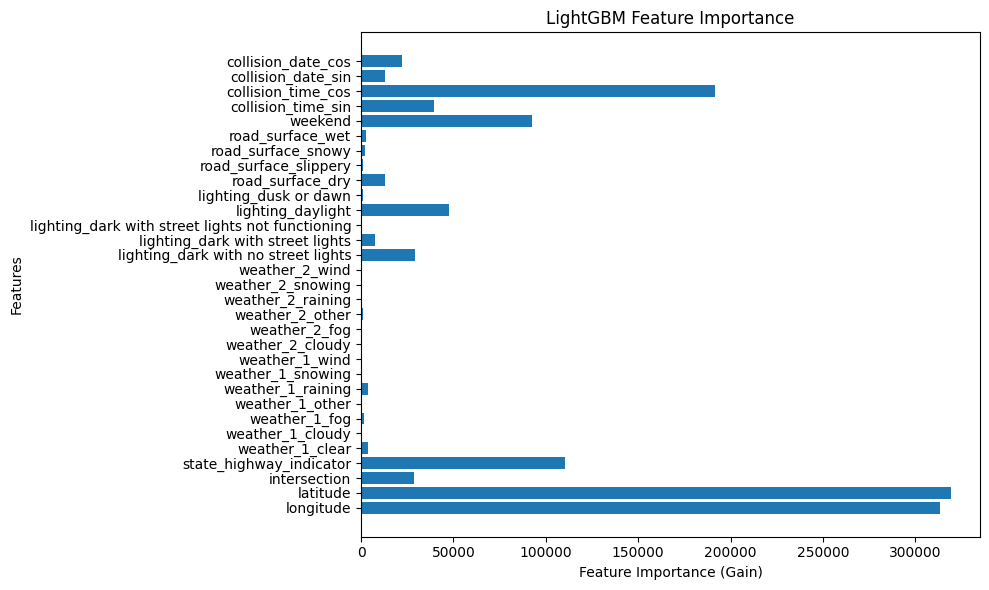

In [24]:
feature_importance = lgb_model.feature_importance(importance_type='gain')
feature_names = X_train.columns
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), feature_importance, align='center')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Features')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

- #### Surprisingly, the analysis revealed that weather conditions were not as influential as one might anticipate in predicting collision severity.

- #### While weather intuitively might have been expected to play a substantial role, its impact on the model's predictions were overshadowed by 'longitude', 'latitude', and 'collision_time'.

- #### The significance of 'longitude' and 'latitude' can be attributed to the fact that more severe collisions tend to occur in densely populated areas such as Los Angeles and San Jose.

- #### The significance of 'collision_time' can be explained by the fact that more severe collisions are likely to happen around rush hour.

In [25]:
import sklearn.metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

#### It's time to look at the confusion matrix.

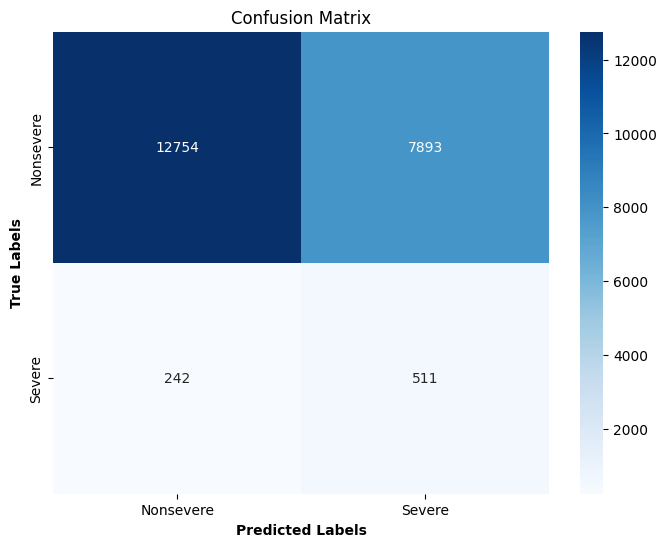

In [26]:
conf_matrix = confusion_matrix(y_test, lgb_preds)
plt.figure(figsize=(8, 6))
labels = ['Nonsevere', 'Severe']
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels", fontweight='bold')
plt.ylabel("True Labels", fontweight='bold')
plt.title("Confusion Matrix")
plt.show()

#### Analyzing the confusion matrix reveals the model's ability to predict 'nonsevere' collisions with an accuracy of 61.77% and 'severe' collisions with a higher accuracy of 67.86%.

#### This is due to the model's prioritization of predicting severe collisions, since over-preparation in scenarios where predicting severe outcomes is crucial.

#### A classification report can also be made to confirm all of this.

              precision    recall  f1-score   support

  Non-Severe       0.98      0.62      0.76     20647
      Severe       0.06      0.68      0.11       753

    accuracy                           0.62     21400
   macro avg       0.52      0.65      0.43     21400
weighted avg       0.95      0.62      0.74     21400



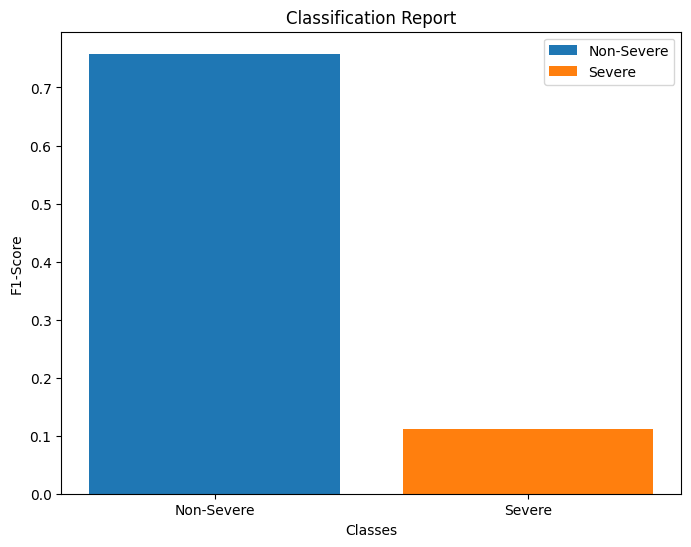

In [27]:
lgb_preds_class = np.round(lgb_preds)

class_names = ['Non-Severe', 'Severe']
report = classification_report(y_test, lgb_preds_class, target_names=class_names, output_dict=True)

print(classification_report(y_test, lgb_preds_class, target_names=class_names))

fig, ax = plt.subplots(figsize=(8, 6))
for key in report.keys():
    row = report[key]
    if key in class_names:
        ax.bar(class_names.index(key), row['f1-score'], label=key)

ax.set_xticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_xlabel('Classes')
ax.set_ylabel('F1-Score')
ax.set_title('Classification Report')
ax.legend()
plt.show()

#### **Although the model's performance is far from perfect and obviously would not be a reliable system for making critical decisions, it serves as a valuable starting point for understanding patterns and trends in the data. This analysis opens the door for iterative improvements, and your input can contribute significantly to refining the model.**

##### For any suggestions or questions, please email me at nicholas.kann@gmail.com. Your feedback is greatly appreciated!
